In [125]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import NSMap as ns
from datetime import date

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
filename = "..\Datasets\Portal_rodent.csv"
filename_trapping_dates = "..\Datasets\Portal_rodent_trapping.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
df = df.astype({"plot":str})
df_trapping_dates = pd.read_csv(filename_trapping_dates, encoding="utf-8", na_filter=False)

In [127]:
"""
Plan of Action: 
 1. Fix to just one species.
 2. Find all plots with fixed treatments over the whole series.
 3. Compare nonstationarity in plots where treatment
    changed versus those where treament stayed the same.

Expected Stationary Plots: 3, 4, 10, 11, 14, 15, 16, 17, 19, 21, 23
Expected Nonstationary Plots: 1, 2, 5-9, 12, 13, 18, 20, 22, 24

"""

stationary_plot_numbers = [3, 4, 10, 11, 14, 15, 16, 17, 19, 21, 23]
nonstationary_plot_numbers = [1, 2, 5, 6, 7, 8, 9, 12, 13, 18, 20, 22, 24]

In [128]:
# the first month of sampling was July of 1977 and it ends in July of 2023, therefore 

def get_species_series(species):
    total_months_elapsed = 46 * 12 + 1
    month_counter = 7
    year_counter = 1977

    table = df[["month", "day", "year", "period", "species"]].query("period >= 0")
    starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
    # table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
    table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)

    trapping_days = df_trapping_dates.query("sampled == 1")[["month", "year"]].to_numpy()

    ts = np.zeros(total_months_elapsed) * np.NAN
    ts_i = 0
    while not (month_counter > 7 and year_counter > 2023):
        did_sampling_occur = np.any(np.logical_and(trapping_days[:,0] == month_counter, trapping_days[:,1] == year_counter))
        if did_sampling_occur:
            is_sample_valid = np.logical_and(table_species[:,0] == month_counter, table_species[:,1] == year_counter)
            ts[ts_i] = np.sum(table_species[is_sample_valid])

        ts_i += 1
        month_counter += 1
        if month_counter > 12:
            month_counter = 1
            year_counter += 1

    t = np.linspace(0,1, num= total_months_elapsed)
    return (ts, t)

In [129]:
def get_plot_series(plot_num):
    total_months_elapsed = 46 * 12 + 1
    month_counter = 7
    year_counter = 1977

    table = df[["month", "day", "year", "period", "plot"]].query(f"period >= 0")
    starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
    
    # table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
    table_species = table.query(f"plot == \"{plot_num}\"")[["month","year"]].to_numpy(dtype=np.int64)
    # table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)
    
    trapping_days = df_trapping_dates.query("sampled == 1")[["month", "year"]].to_numpy()

    ts = np.zeros(total_months_elapsed) * np.NAN
    ts_i = 0
    while not (month_counter > 7 and year_counter > 2023):
        sampling_did_occur = np.any(np.logical_and(trapping_days[:,0] == month_counter, trapping_days[:,1] == year_counter))
        if sampling_did_occur:
            is_sample_valid = np.logical_and(table_species[:,0] == month_counter, table_species[:,1] == year_counter)
            ts[ts_i] = np.sum(table_species[is_sample_valid])

        ts_i += 1
        month_counter += 1
        if month_counter > 12:
            month_counter = 1
            year_counter += 1

    t = np.linspace(0,1, num= total_months_elapsed)
    return (ts, t)

In [130]:
def get_species_plot_series(species, plot_num):
    total_months_elapsed = 46 * 12 + 1
    month_counter = 7
    year_counter = 1977

    table = df[["month", "day", "year", "species", "period", "plot"]].query(f"period >= 0")
    starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
    
    # table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
    table_species = table.query(f"plot == \"{plot_num}\" and species == \"{species}\"")[["month","year"]].to_numpy(dtype=np.int64)
    # table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)
    
    trapping_days = df_trapping_dates.query("sampled == 1")[["month", "year"]].to_numpy()

    ts = np.zeros(total_months_elapsed) * np.NAN
    ts_i = 0
    while not (month_counter > 7 and year_counter > 2023):
        sampling_did_occur = np.any(np.logical_and(trapping_days[:,0] == month_counter, trapping_days[:,1] == year_counter))
        if sampling_did_occur:
            is_sample_valid = np.logical_and(table_species[:,0] == month_counter, table_species[:,1] == year_counter)
            ts[ts_i] = np.sum(table_species[is_sample_valid])

        ts_i += 1
        month_counter += 1
        if month_counter > 12:
            month_counter = 1
            year_counter += 1

    t = np.linspace(0,1, num= total_months_elapsed)
    return (ts, t)

In [131]:
# fetches the sum of all species from a particular control site
def get_species_control_series(species):
    control_only_plots = [4 , 11, 14, 17]
    
    ts, t = get_species_plot_series(species, control_only_plots[0])
    for plot_id in control_only_plots[1:]:
        ts += get_species_plot_series(species, plot_id)[0]
    
    return (ts, t)

In [336]:
# Given a species name, return the raw abundance time series as well as
# the times of each observation(standardized between 0 and 1)
# 
species = "NA"

table = df[["month", "day", "year", "period", "species"]].query("period >= 0")
starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
# table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)

np.unique(table_species)

"""
observation_days = [(date(year, month, day) - starting_date).days for month, day, year in table_species]

# first create a time series for each trapping month to make sure we include true 0s

trapping_days_dates = [date(year, month, day) for day, month, year in trapping_days]
trapping_day_months = [date(year, month, day) for day, month, year in trapping_days]

# then find the abundance for each day
trapping_day_numbers = np.unique(np.array([(date - trapping_days_dates[0]).days for date in trapping_days_dates]))

# now for each observation day, add up all trappings (if any)
ts_raw = np.array([np.sum(observation_days == trapping_day_number) for trapping_day_number in trapping_day_numbers])

# aggregate for each month
mi = trapping_days_dates[0].month
yi = trapping_days_dates[0].year

last_month = trapping_days_dates[-1].month
last_year = trapping_days_dates[-1].year

ts_intermediate = []
while not (mi > last_month and yi > last_year):
    valid_months = np.array([date.year == yi and date.month == mi for date in trapping_days_dates])
    
    ts_intermediate = ts_intermediate + [np.sum(ts_raw, where=valid_months)]
    
    mi += 1
    if mi > 12:
        mi = 1
        yi = yi + 1
    
ts = np.array(ts_intemediate)
t = trapping_day_numbers / trapping_day_numbers[-1]
"""
# return (ts, t)

'\nobservation_days = [(date(year, month, day) - starting_date).days for month, day, year in table_species]\n\n# first create a time series for each trapping month to make sure we include true 0s\n\ntrapping_days_dates = [date(year, month, day) for day, month, year in trapping_days]\ntrapping_day_months = [date(year, month, day) for day, month, year in trapping_days]\n\n# then find the abundance for each day\ntrapping_day_numbers = np.unique(np.array([(date - trapping_days_dates[0]).days for date in trapping_days_dates]))\n\n# now for each observation day, add up all trappings (if any)\nts_raw = np.array([np.sum(observation_days == trapping_day_number) for trapping_day_number in trapping_day_numbers])\n\n# aggregate for each month\nmi = trapping_days_dates[0].month\nyi = trapping_days_dates[0].year\n\nlast_month = trapping_days_dates[-1].month\nlast_year = trapping_days_dates[-1].year\n\nts_intermediate = []\nwhile not (mi > last_month and yi > last_year):\n    valid_months = np.array(

In [87]:
# First we find the 3 most abundant species

all_species = df["species"].unique()
total_observed = np.zeros(all_species.shape)
for i, species in enumerate(all_species):
    ts, t = get_species_control_series(species)
    
    total_observed[i] = np.sum(ts, where=np.isfinite(ts))

In [88]:
sorted_indices = np.flip(np.argsort(total_observed))
all_species_sorted = all_species[sorted_indices]
total_observed_sorted = total_observed[sorted_indices]

three_most_abundant = all_species_sorted[:3]

In [89]:
three_most_abundant

array(['DM', 'PP', 'DO'], dtype=object)

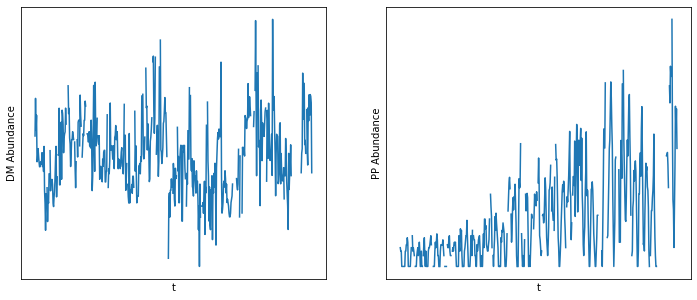

In [121]:
fig_ts, ax_ts = plt.subplots(1,2, figsize=(12,5))

for i, species in enumerate(three_most_abundant[:2]):
    ts_raw, t = get_species_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    ax_ts[i].plot(t, ts, label=species)
    ax_ts[i].set_ylabel(species+ " Abundance")
    
    ax_ts[i].set_yticks([])
    ax_ts[i].set_xticks([])
    ax_ts[i].set_xlabel("t")

In [94]:
E_max = 10
taus = np.arange(1,12)
r_sqrd_table = np.zeros((len(taus), 3))

In [177]:
# Determine tau and E

In [99]:
for i, species in enumerate(three_most_abundant):
    
    ts_raw, t = get_species_control_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))

    r_sqrds = [ns.get_delta_agg(ts, E_max, tau=tau, t=t,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:, i] = r_sqrds
    
np.savetxt("../results/portal_rodent_analysis/portal_rodent_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")

In [100]:
# Check Autocorrelation

autocorr_table = np.zeros((len(taus),3))

for i, species in enumerate(three_most_abundant):
    ts_raw, t = get_species_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    ts_noNANs = ts[np.isfinite(ts)]
    
    autocorr_table[:,i] = np.array([np.corrcoef(ts_noNANs[tau:],
                                           ts_noNANs[:-tau])[0,1]
                               for tau in taus])

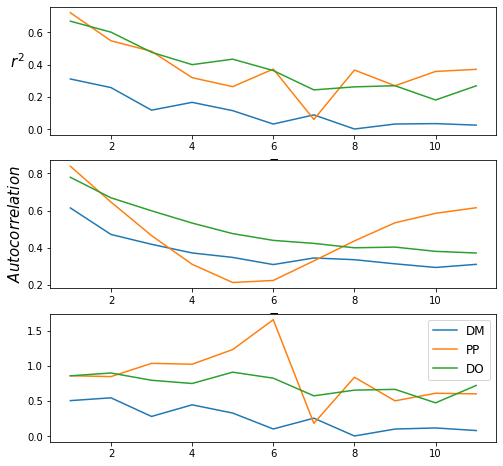

In [103]:
r_sqrd_table = np.loadtxt("../results/portal_rodent_analysis/portal_rodent_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(3,figsize=(8,8))

for i, species in enumerate(three_most_abundant):
    ax[0].plot(taus, r_sqrd_table[:,i], label=species)
    ax[1].plot(taus, autocorr_table[:,i], label=species)
    ax[2].plot(taus, r_sqrd_table[:,i] / autocorr_table[:,i], label=species)

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend(fontsize = 12)

In [122]:
"""
Tau determination: from the above plot, tau=2 is a great choice because it takes 
the autocorrelation down to 0.7 while preserving a quite strong prediction skill of 
around 0.81.

For E_max, we choose the above 7 the product of that is 49 and that gives a 
decently large embedding window
"""

tau = [2, 2, 2]
E_max = [10, 10, 10]

In [123]:
three_most_abundant

array(['DM', 'PP', 'DO'], dtype=object)

In [124]:
# Finally assess the nonstationarity

for i, species in enumerate(three_most_abundant):
    ts_raw, t = get_species_series(species)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    delta, theta, r_sqrd = ns.get_delta_agg(ts, E_max[i], tau=tau[i], t=t,
                                            return_forecast_skill=True)
    print(f"delta = {delta:.2f}, theta = {theta:.2f}, r_sqrd = {r_sqrd:.2f}")

delta = 0.00, theta = 0.43, r_sqrd = 0.34
delta = 6.66, theta = 0.00, r_sqrd = 0.60
delta = 1.47, theta = 0.00, r_sqrd = 0.53


plot = 3, delta = 0.00, theta = 0.00, r_sqrd = 0.15
plot = 4, delta = 0.00, theta = 0.00, r_sqrd = 0.06
plot = 10, delta = 4.87, theta = 0.00, r_sqrd = 0.10
plot = 11, delta = 6.43, theta = 0.58, r_sqrd = 0.21
plot = 14, delta = 0.00, theta = 0.71, r_sqrd = 0.13
plot = 15, delta = 0.00, theta = 0.56, r_sqrd = 0.25
plot = 16, delta = 0.91, theta = 0.00, r_sqrd = 0.08
plot = 17, delta = 0.00, theta = 0.00, r_sqrd = 0.16
plot = 19, delta = 0.00, theta = 0.26, r_sqrd = 0.30
plot = 21, delta = 19.07, theta = 0.00, r_sqrd = 0.29
plot = 23, delta = 3.02, theta = 0.00, r_sqrd = 0.02


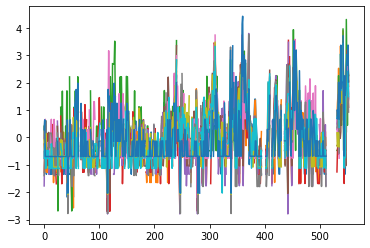

In [356]:
# Assess Nonstationarity of the No Treatment Change Plot
for i in stationary_plot_numbers:
    ts_raw, t = get_plot_series(i)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    plt.plot(ts)
    
    delta, theta, r_sqrd = ns.get_delta_agg(ts, E_max, tau=tau, t=t, return_forecast_skill=True)
    print(f"plot = {i}, delta = {delta:.2f}, theta = {theta:.2f}, r_sqrd = {r_sqrd:.2f}")

plot = 1, delta = 76.89, theta = 0.01, r_sqrd = 0.33
plot = 2, delta = 0.00, theta = 0.60, r_sqrd = 0.15
plot = 5, delta = 0.00, theta = 0.33, r_sqrd = 0.23
plot = 6, delta = 0.01, theta = 1.30, r_sqrd = 0.27
plot = 7, delta = 95.66, theta = 0.00, r_sqrd = 0.32
plot = 8, delta = 0.00, theta = 0.00, r_sqrd = 0.15
plot = 9, delta = 11.79, theta = 1.01, r_sqrd = 0.27
plot = 12, delta = 5.94, theta = 0.00, r_sqrd = 0.32
plot = 13, delta = 0.00, theta = 0.00, r_sqrd = 0.12
plot = 18, delta = 0.00, theta = 0.00, r_sqrd = 0.22
plot = 20, delta = 0.00, theta = 1.33, r_sqrd = 0.28
plot = 22, delta = 0.00, theta = 0.00, r_sqrd = 0.29
plot = 24, delta = 0.00, theta = 0.00, r_sqrd = 0.23


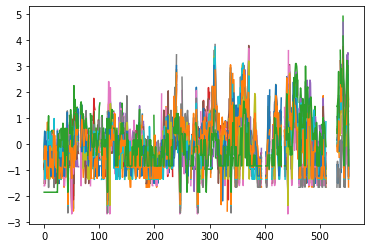

In [355]:
# Assess Nonstationarity of the treatment change plots
for i in nonstationary_plot_numbers:
    ts_raw, t = get_plot_series(i)
    ts = ns.standardize(np.sqrt(ts_raw))
    
    plt.plot(ts)
    
    delta, theta, r_sqrd = ns.get_delta_agg(ts, E_max, tau=tau, t=t, return_forecast_skill=True)
    print(f"plot = {i}, delta = {delta:.2f}, theta = {theta:.2f}, r_sqrd = {r_sqrd:.2f}")

In [54]:
control_only_plots = [4 , 11, 14, 17]

for i in control_only_plots:
    print(np.sum(get_plot_series(i)[0], where=np.isfinite(get_plot_series(i)[0])))

8711617.0
7974658.0
8192030.0
8844751.0


In [59]:
# Top 2 most abundant control plot species

control_only_plots = [4 , 17]
r_sqrd_table = np.zeros((len(taus), 2))
index = 0

for i in control_only_plots:
    ts, t = get_plot_series(i)
    ts = ns.standardize(np.sqrt(ts))
    
    r_sqrds = [ns.get_delta_agg(ts, E_max, tau=tau, t=t,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:, index] = r_sqrds
    
    index += 1

KeyboardInterrupt: 

In [58]:
E_max = 10
taus = np.arange(1,12)

In [41]:
r_sqrd_table = np.array([ns.get_delta_agg(ts, E_max, tau=tau, t=t,
                         return_forecast_skill=True)[2] 
               for tau in taus])

np.savetxt("../results/portal_rodent_analysis/portal_rodent_control_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")

In [42]:
# Check Autocorrelation

ts_noNANs = ts[np.isfinite(ts)]

autocorr_table = np.array([np.corrcoef(ts_noNANs[tau:],
                                       ts_noNANs[:-tau])[0,1]
                           for tau in taus])

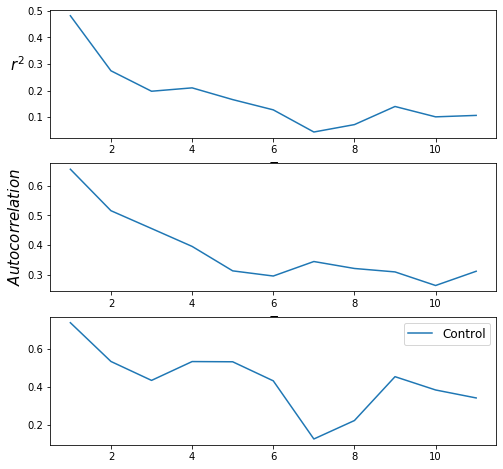

In [43]:
r_sqrd_table = np.loadtxt("../results/portal_rodent_analysis/portal_rodent_control_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(3,figsize=(8,8))

ax[0].plot(taus, r_sqrd_table, label="Control")
ax[1].plot(taus, autocorr_table, label="Control")
ax[2].plot(taus, r_sqrd_table / autocorr_table, label="Control")

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend(fontsize = 12)

In [47]:
tau = 1
E_max = 12

delta, theta, r_sqrd = ns.get_delta_agg(ts, E_max, tau=tau, t=t, return_forecast_skill=True)
print(f"delta = {delta:.2f}, theta = {theta:.2f}, r_sqrd = {r_sqrd:.2f}")

delta = 0.00, theta = 0.11, r_sqrd = 0.46


In [8]:
# Test for Tanya

filename = "testseries.csv"

df_tanya_test = pd.read_csv(filename, encoding="utf-8", na_filter=False)

In [19]:
ids = df_tanya_test["survey"].unique()

In [30]:
df_tanya_test

,survey,year,wtcpue_mean,ID
0,EBS,1983,26478.640778,EBS
1,EBS,1984,22056.620659,EBS
2,EBS,1985,19411.808988,EBS
3,EBS,1986,20023.841437,EBS
4,EBS,1987,21418.839971,EBS
...,...,...,...,...
267,SWC-IBTS,2015,6694.565351,SWC-IBTS
268,SWC-IBTS,2016,11746.491383,SWC-IBTS
269,SWC-IBTS,2017,15094.015979,SWC-IBTS
270,SWC-IBTS,2018,6174.181393,SWC-IBTS


id = EBS, delta = 0.00, theta = 0.00, r_sqrd = 0.13
id = GMEX, delta = 0.40, theta = 0.00, r_sqrd = 0.23
id = GSL-S, delta = 1.45, theta = 0.00, r_sqrd = 0.03
id = NEUS, delta = 0.12, theta = 0.11, r_sqrd = 0.23
id = NS-IBTS, delta = 0.09, theta = 0.00, r_sqrd = 0.00
id = SCS, delta = 0.47, theta = 0.00, r_sqrd = 0.72
id = SEUS, delta = 2.77, theta = 0.00, r_sqrd = 0.40
id = SWC-IBTS, delta = 0.13, theta = 0.43, r_sqrd = 0.14


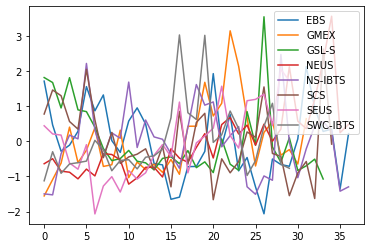

In [34]:
for ID in ids:
    series = df_tanya_test.query(f"survey == \"{ID}\"")["wtcpue_mean"].to_numpy()
    series_standardize = ns.standardize(series)
    plt.plot(series_standardize, label = f"{ID}")
    
    delta, theta, r_sqrd = ns.get_delta_agg(series_standardize, 4, tau=1, return_forecast_skill=True)
    
    print(f"id = {ID}, delta = {delta:.2f}, theta = {theta:.2f}, r_sqrd = {r_sqrd:.2f}")
    
plt.legend()